In [1]:
#Forest Damage Prediction
#download Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV

In [4]:
#read dataset
data = pd.read_csv("/kaggle/input/forest-fires-data-set/forestfires.csv")    #reading the dataset
data.head(10)    #show the first 15 instances of dataset

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0


In [3]:
data.tail(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00
516,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,0.00


In [5]:
data.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [8]:
#check missing values
data.isna().sum().sum()

0

In [10]:
#given area of land burnt, but we have to predict if there is fire or not so changing values of area to 0 and 1 only
#here 0 represet there is not fire and 1 represent fire, changing all values of area which are greater than 0 to 1
data['area'].values[data['area'].values > 0] = 1

In [11]:
#correlation
data.corr()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.065003,-0.024922,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.062491
Y,0.539548,1.000000,-0.066292,-0.005453,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.056892
month,-0.065003,-0.066292,1.000000,-0.050837,0.291477,0.466645,0.868698,0.186597,0.368842,-0.095280,-0.086368,0.013438,0.130329
day,-0.024922,-0.005453,-0.050837,1.000000,-0.041068,0.062870,0.000105,0.032909,0.052190,0.092151,0.032478,-0.048340,-0.042970
FFMC,-0.021039,-0.046308,0.291477,-0.041068,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.073823
DMC,-0.048384,0.007782,0.466645,0.062870,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.062672
DC,-0.085916,-0.101178,0.868698,0.000105,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.096724
ISI,0.006210,-0.024488,0.186597,0.032909,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.035663
temp,-0.051258,-0.024103,0.368842,0.052190,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.076047
RH,0.085223,0.062221,-0.095280,0.092151,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.035587


<Axes: >

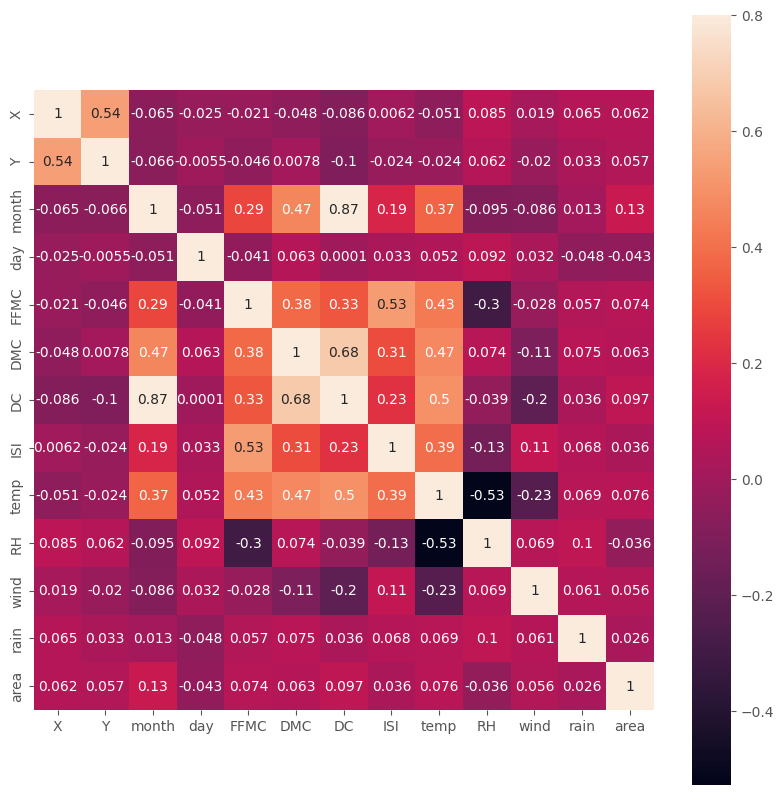

In [12]:
#heatmap
corr=data.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr,vmax=0.8,square=True,annot=True)

In [22]:
def ordinal_encode(data, column, ordering):
    data = data.copy()
    data[column] = data[column].apply(lambda x: ordering.index(x))
    return data

In [18]:
def preprocess_inputs(df, task='regression'):
    df = df.copy()
    
    # Ordinal encode month and day columns
    month_ordering = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    day_ordering = ['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat']
    
    data['month'] = data['month'].apply(lambda x: month_ordering.index(x) + 1)
    data['day'] = data['day'].apply(lambda x: day_ordering.index(x) + 1)
    
    # Split df into X and y
    if task == 'regression':
        y = data['area']
    elif task == 'classification':
        y = data['area'].apply(lambda x: 1 if x > 0 else 0)
    
    X = df.drop('area', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale feature data (X)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test


In [19]:
#regression
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r2 = r2_score(y_test, y_pred)
print("R-squared (R^2):", r2)


Mean Squared Error: 0.009511914910418966
Mean Absolute Error (MAE): 0.07773328130097601
Root Mean Squared Error (RMSE): 0.09752904649600018
R-squared (R^2): 0.9999994362016347


In [24]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of regression models
models = {
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR()
}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    # Print the evaluation metrics
    print(f"Model: {name}")
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R-squared:", r2)
    print("\n")

Model: Ridge Regression
Mean Squared Error: 0.037564056913852714
Mean Absolute Error: 0.158522699339505
Root Mean Squared Error: 0.19381449098004183
R-squared: 0.9999977734710536


Model: Lasso Regression
Mean Squared Error: 9.704309266952665
Mean Absolute Error: 2.477820452854286
Root Mean Squared Error: 3.1151740347776182
R-squared: 0.999424797871616


Model: Random Forest Regressor
Mean Squared Error: 2511.2944226340223
Mean Absolute Error: 39.57576379765959
Root Mean Squared Error: 50.11281694969883
R-squared: 0.8511484066344331


Model: Gradient Boosting Regressor
Mean Squared Error: 1234.7010418760865
Mean Absolute Error: 28.910997250026277
Root Mean Squared Error: 35.138313019780654
R-squared: 0.9268157426079049


Model: Support Vector Regressor
Mean Squared Error: 12758.14612986086
Mean Absolute Error: 89.70507889979308
Root Mean Squared Error: 112.95196381586669
R-squared: 0.24378823816737072




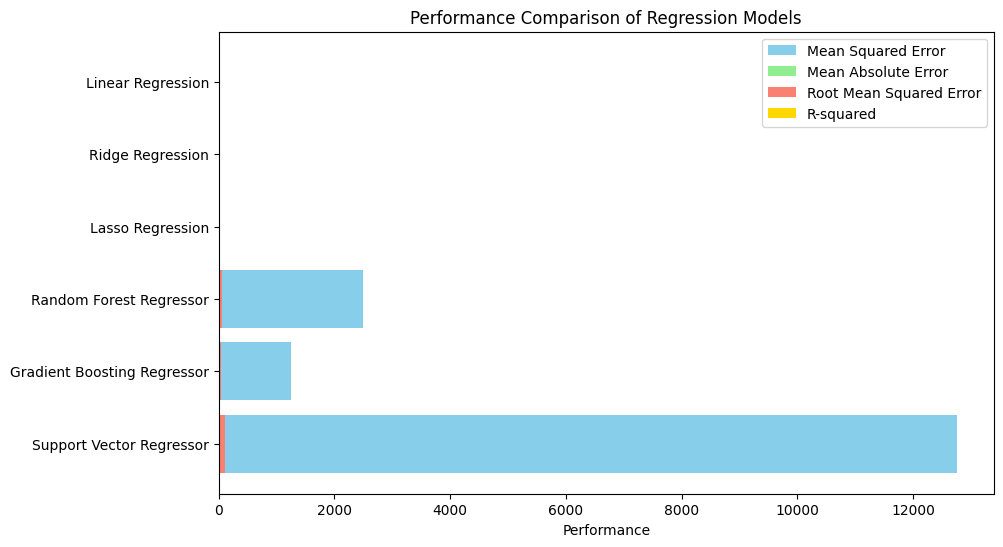

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of regression models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR()
}

# Initialize lists to store evaluation metrics
mse_values = []
mae_values = []
rmse_values = []
r2_values = []
model_names = []

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    # Append evaluation metrics to lists
    mse_values.append(mse)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    model_names.append(name)

# Plot the evaluation metrics
plt.figure(figsize=(10, 6))
plt.barh(model_names, mse_values, color='skyblue', label='Mean Squared Error')
plt.barh(model_names, mae_values, color='lightgreen', label='Mean Absolute Error')
plt.barh(model_names, rmse_values, color='salmon', label='Root Mean Squared Error')
plt.barh(model_names, r2_values, color='gold', label='R-squared')
plt.xlabel('Performance')
plt.title('Performance Comparison of Regression Models')
plt.legend()
plt.gca().invert_yaxis()
plt.show()